In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import trange
import time

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# data splitting and outlier removal
import  sklearn.preprocessing  # StandardScaler
from sklearn.ensemble import IsolationForest
import sklearn.model_selection #  train_test_split
import colossus
from colossus.cosmology import cosmology
# Set tensor numeric type.
dtype = 'float32'

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # to cycle through palette colors
if 1== 1 :
  sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
  )
sns.set_palette(palette='deep')
#sns.set_palette(palette="Paired_r")
#sns_c = sns.color_palette(palette="Paired_r")
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Get TensorFlow version.
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))



2021-10-25 20:26:31.055221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/job/2.2.4-7.0.1.1_3.54__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2019.3.199/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2019.3.199/linux/mkl/lib/intel64:/usr/common/software/darshan/3.2.1/lib
2021-10-25 20:26:31.055236: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.8.0-dev20211012
TensorFlow Probability version: 0.15.0-dev20211013


2021-10-25 20:26:43.879690: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-25 20:26:43.892017: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-25 20:26:43.892039: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nid00573): /proc/driver/nvidia/version does not exist


## Plotting codes

In [2]:
def plot_boxplot(posterior_samples):
  fig, axes = plt.subplots(1, 4, figsize=(16, 4))

  # Invert the results dict for easier plotting.
  #k = list(posterior_samples.values())[0].keys()
  k = list(posterior_samples.keys())
  #print("p,k:", posterior_samples["HMC"].keys(), posterior_samples.keys())
  type_keys = posterior_samples.keys()
  for tkey in type_keys:
    var_keys=posterior_samples[tkey].keys()
    
  vlist = []
  for vkey in var_keys:
    tlist = []
    for tkey in type_keys :
        #print (vkey, tkey, "   = ", posterior_samples[tkey][vkey].shape)
        tlist.append(posterior_samples[tkey][vkey])
    vlist.append( [vkey, type_keys, tlist] )  

  for i, (var, tvar, var_results) in enumerate(vlist):
    sns.boxplot(data=list(var_results), ax=axes[i],
                width=0.18*len(var_results), whis=(2.5, 97.5))
    # axes[i].boxplot(list(var_results.values()), whis=(2.5, 97.5))
    axes[i].title.set_text(var)
    fs = 10 if len(var_results) < 4 else 8
    axes[i].set_xticklabels(tvar, fontsize=fs)  
    
def plot_chain_traces(params, num_chains, chains_df) :
    fig, axes = plt.subplots(nrows=len(params), ncols=2, figsize=(10, 8), constrained_layout=True)

    for i, param in enumerate(params):
        if num_chains < 6 :
            sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
        else :
            sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, bins=70,  
                         ax=axes[i][0], legend=False)
        sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', 
                     alpha=0.3, legend=False, ax=axes[i][1])

    fig.suptitle('Posterior Samples per Chain', y=1.03);
 
def plot_chain_sum(params, chains_df) :
    fig, axes = plt.subplots(nrows=int((len(params)/2.)), 
            ncols=2, figsize=(9, 6), constrained_layout=True)
    
    palette = itertools.cycle(sns.color_palette())
    # color
    c = next(palette)

    ii=0; jj=0
    for i, param in enumerate(params):
        sns.histplot(x=param, data=chains_df, kde=True, ax=axes[ii][jj], color=c)
        axes[ii][jj].axvline(
            x=chains_df[param].mean(), 
            linestyle='--',
            color="black",
            label='mean = {:10.3f}\nstd     = {:10.3f}'.format(
                chains_df[param].mean(),chains_df[param].std())
        )
        axes[ii][jj].legend(loc='upper right') 
        c = next(palette)
        jj+=1; 
        if jj==2: 
            jj=0; ii+=1

    fig.suptitle('Posterior Samples', y=1.03);
    
# for wide spread use
# ppd_df is the output of make_posterior_predictive_distribution
def yp_on_yt_plot (y_predictions, y_sigma, y_test, ppd_df) :
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), constrained_layout=True)

    ax[0].errorbar( x=np.array(y_test), y=y_predictions, yerr=y_sigma,fmt='o',
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals')
    sns.regplot(x=np.array(y_test), y=y_predictions,
        scatter=False, line_kws=dict(alpha=0.5), fit_reg=True, label="linear regression", 
        truncate=False, ax=ax[0])
    ax[0].plot(ppd_df["range"],ppd_df["mean"], color="black", label="y=x, 90% posterior predictive")
    ax[0].fill_between(ppd_df["range"], ppd_df["90l"], ppd_df["90u"], color='k', alpha=.1)
    ax[0].set(title='Model Predictions for Test Sample', xlabel='y',ylabel='y_pred');
    ax[0].legend(loc='lower right')
         
    ax[1].errorbar( x=np.array(y_test), y=y_predictions-np.array(y_test), yerr=y_sigma,fmt='o', 
        #ecolor=sns_c[1], mfc=sns_c[4],
        ecolor="r", mfc="r", mec="k", capsize=2, label='predictions + credible intervals',)
    sns.regplot(x=np.array(y_test), y = y_predictions-np.array(y_test),
        scatter=False, line_kws=dict(alpha=0.5),  fit_reg=True, label="linear regression",  
        truncate=False,  ax=ax[1])
    ax[1].plot(ppd_df["range"],np.zeros(ppd_df["mean"].size), 
               color="black", label="y=x, 90% posterior predictive")
    ax[1].fill_between(ppd_df["range"], ppd_df["90l"]-ppd_df["mean"], ppd_df["90u"]-ppd_df["mean"], color='k', alpha=.1)
    ax[1].set(title='Delta Model Predictions for Test Sample', xlabel='y', ylabel='y_pred');
    ax[1].legend(loc='lower right')

# this is probably a special purpose HMC code
def plot_hmc_distributions(answers, y_test) :
    plt.figure(figsize=(12, 8))
    residuals = answers["posterior_mean"]-y_test

    mu_post_dist = answers["mu_posterior_dist"]
    post_dist = answers["posterior_dist"]
    shapes = post_dist.get_shape().as_list()

    # Get y_test into a shape that can be subtracted to every entry in post_dist
    yt = tf.constant(y_test, dtype=dtype)
    yt = tf.broadcast_to(yt, [shapes[1],shapes[0]])
    yt = tf.transpose(yt)

    # make them all residuals
    post_dist = post_dist-yt
    mu_post_dist = mu_post_dist-yt
    # get rid of structure now that they are all residuals
    post_dist = tf.squeeze(tf.reshape(post_dist, [1,-1]))
    mu_post_dist = tf.squeeze(tf.reshape(mu_post_dist, [1,-1]))

    #fig.legend(loc="upper right")
    #fig.suptitle('Posterior Samples', y=1.03);
    sns.histplot(x=post_dist, kde=True, stat="density", color="blue", alpha=0.75)
    sns.histplot(x=mu_post_dist, kde=True, stat="density", color="green", alpha=0.45)
    sns.histplot(x=residuals, kde=False, stat="density", color="black", alpha=0.35)
 # 

### definitions for use

In [3]:
def chains_to_df (chain, num_chains, params) :
    print("\n==== chains_to_df is dependent on the order & number of parameters in the chain\n")
    i = 0; dict= {}
    dict[params[0]] =  chain[0][:,i].numpy()
    dict[params[1]] =  chain[1][...,0][:,i].numpy()
    dict[params[2]] =  chain[1][...,1][:,i].numpy()
    dict[params[3]] =  chain[2][:,i].numpy()
    size = chain[0][:,i].numpy().size
    dict["chain_id"]= (np.ones(size)*(i+1)).astype("int")
    dict["chain_sample_id"]= range(size) 
    for i in range(1,num_chains) :
        dict[params[0]] = np.append(dict[params[0]], chain[0][:,i].numpy() )
        dict[params[1]] = np.append(dict[params[1]], chain[1][...,0][:,i].numpy() )
        dict[params[2]] = np.append(dict[params[2]], chain[1][...,1][:,i].numpy() )    
        dict[params[3]] = np.append(dict[params[3]], chain[2][:,i].numpy() )
        dict["chain_id"] = np.append(dict["chain_id"], (np.ones(size)*(i+1)).astype("int"))
        dict["chain_sample_id"] = np.append(dict["chain_sample_id"], range(size))
                                 
    chains_df = pd.DataFrame(dict)
    return chains_df

def make_posterior_means_from_chains(chains, X_test, y_test , params, verbose=False) :
    x_star = tf.cast(tf.squeeze(X_test), dtype)
    alpha_ch = chains[0]
    beta_ch  = chains[1]
    sigma_ch = chains[2]
    # stack all the chains into one long tensor, for each alpnh,beta,sigma
    alpha = tf.squeeze(tf.reshape(alpha_ch, [-1,1]))
    sigma = tf.squeeze(tf.reshape(sigma_ch, [-1,1]))
    beta = tf.squeeze(tf.reshape(beta_ch, [-1,1,2]))

    if verbose: 
      print("X_test  ", X_test.shape)
      print("x_star  ", x_star.shape)
      print("alpha  ", alpha.shape)
      print("beta  ", beta.shape)
      print("sigma  ", sigma.shape)
    # shapes_ch = alpha_ch.get_shape().as_list()
    # size = shapes_ch[0]*shapes_ch[1]

    # Here we compute mu = alpha + beta x.
    beta_x = tf.linalg.matmul(x_star, tf.transpose(beta) )
    if verbose: 
      print("beta_x  ", beta_x.shape)

    # compute mcmc posterior predictive distribution 
    mu_y_pred = alpha + beta_x
    if verbose: print("mu_y_star  ", mu_y_pred.shape)
    
    mu_posterior_mean = tf.math.reduce_mean(mu_y_pred, axis=1).numpy()
    mu_posterior_std = tf.math.reduce_std(mu_y_pred, axis=1).numpy()
    if verbose:print ("mu_posterior_mean  ",mu_posterior_mean.shape)

    # compute posterior predictive distribution from mu_posterior_mean and 
    # the chain computed sigma
    ppd_y_pred = tf.map_fn(
        fn=lambda z: tfd.Normal(loc=z, scale=sigma).sample(1), 
        elems=mu_posterior_mean    )
    ppd_y_pred = tf.squeeze(ppd_y_pred)
    if verbose: print("ppd_y_pred  ", ppd_y_pred.shape)

    posterior_mean = tf.math.reduce_mean(ppd_y_pred, axis=1).numpy()
    posterior_std = tf.math.reduce_std(ppd_y_pred, axis=1).numpy()
    if verbose: print ("posterior_mean  ",posterior_mean.shape)

    mu_chisq = (((mu_posterior_mean-y_test)/mu_posterior_std)**2).sum()/(y_test.size-len(params)-1)
    mu_rms = np.sqrt(((mu_posterior_mean-y_test)**2).sum()/y_test.size)
    chisq = (((posterior_mean-y_test)/posterior_std)**2).sum()/(y_test.size-len(params)-1)
    rms = np.sqrt(((posterior_mean-y_test)**2).sum()/y_test.size)

    print("\n Test data\n")
    print ("mu_posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(mu_chisq,mu_rms))
    print ("   posterior_std  chi-sq and rms: {:6.2f} {:6.3f}".format(chisq, rms))

    # prepare the fit and confidence interval: weirdly, assuming that the only thing that matters is sigma
    # becuse it is a posterior predictive distribution 
    ppd_df = make_posterior_predictive_distribution (tf.math.reduce_mean(sigma))

    answers={}
    answers["mu_posterior_mean"] = mu_posterior_mean
    answers["mu_posterior_std"] = mu_posterior_std
    answers["mu_posterior_dist"] = mu_y_pred
    answers["posterior_mean"] = posterior_mean
    answers["posterior_std"] = posterior_std
    answers["posterior_dist"] = ppd_y_pred
    answers["ppd_df"] = ppd_df

    return answers

def make_posterior_predictive_distribution (sigma, verbose=False) :
    # prepare the fit and confidence interval: weirdly, assuming that the only thing that matters is sigma
    # becuse it is a posterior predictive distribution 
    range_x = np.arange(14.0,15.0,0.05) ; 
    if verbose : print("range_x: ", range_x.shape)
    range_y = tf.map_fn(
        fn=lambda z: tfd.Normal(loc=z, scale=sigma).sample(20000), 
        elems=tf.constant(range_x , dtype=dtype )  )
    range_y = tf.squeeze(range_y)
    if verbose: print("range_y  ", range_y.shape)

    range_mean = tf.math.reduce_mean(range_y, axis=1).numpy()
    range_std = tf.math.reduce_std(range_y, axis=1).numpy()
    range_90l = range_mean - 2*range_std
    range_90u = range_mean + 2*range_std
    df = pd.DataFrame({"mean": range_mean})
    df["range"]= range_x
    df["std"]= range_std
    df["90l"]= range_90l
    df["90u"]= range_90u
    return df
#

In [4]:
cluster_data=pd.read_csv("~/Data/cluster_data_0.3-0.6-msm.csv")
clusters = pd.DataFrame( {"central_sm":cluster_data["central_sm"]} )
clusters["measured_sm"] = cluster_data["measured_sm"]
clusters["halo_mass"] = cluster_data["halo_mass"]
clusters.head()

,central_sm,measured_sm,halo_mass
0,12.115618,12.491581,14.658120
1,11.894872,12.111751,14.089678
2,11.763473,12.208368,14.383239
3,11.820660,12.358756,14.287383
4,11.628624,12.131789,14.141557


In [5]:


train,test = sklearn.model_selection.train_test_split(clusters, train_size=0.80)
X = train[train.columns[:-1]]
y = train[train.columns[-1]]
print("X, y:", X.shape, y.shape)
X_test = test[test.columns[:-1]]
y_test = test[test.columns[-1]]
all_X = clusters[clusters.columns[:-1]]
all_y = clusters[clusters.columns[-1]]

train = tf.data.Dataset.from_tensor_slices( (X, y)).shuffle(10000).batch(1000)

X=X.astype(dtype)
X_test=X_test.astype(dtype)
y=y.astype(dtype)
y_test=y_test.astype(dtype)
all_X = all_X.astype(dtype)
all_y = all_y.astype(dtype)

# Are these globals?
x = X
y = y

X, y: (229, 2) (229,)


## Define the physical model

In [9]:
#tf.keras.backend.clear_session()
# Define the probabilistic graphical model as a JointDistribution.
def out_y_point (alpha, beta, x) :
    beta = tf.reshape(beta,[2,-1])
    return tf.linalg.matmul(x, beta) + alpha
def out_y (alpha, beta, sigma, x) :
    return tfd.Normal( loc=out_y_point(alpha, beta, x), scale=sigma, name="y")

@tfd.JointDistributionCoroutineAutoBatched
def model_standard():
    alpha = yield  tfd.Normal( loc=5.0, scale=3, name="alpha")
    beta =  yield tfd.Normal( loc=[0.5,0.5], scale=[3.0,3.0], name="beta")
    sigma = yield tfd.HalfNormal(scale=0.5, name="sigma")                                   
    y = yield  out_y(alpha, beta, sigma, x)
    
@tfd.JointDistributionCoroutineAutoBatched
def model_yyz():
    alpha = yield  tfd.Normal( loc=3.0, scale=6.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    sigma = yield tfd.HalfNormal(scale=1.0, name="sigma")
    q = yield tfd.Normal ( loc=0.0, scale=1.0, name="q")                                   
    y = yield  out_y(alpha, beta, (sigma + q* (out_y_point(alpha, beta, x)-12.0)), x)
    
@tfd.JointDistributionCoroutineAutoBatched
def model_vector():
    alpha = yield  tfd.Normal( loc=3.0, scale=6.0, name="alpha")
    beta =  yield tfd.Normal( loc=[0.0,0.0], scale=[3.0,3.0], name="beta")
    sigma = yield tfd.HalfNormal(
                loc=(out_y_point(alpha,beta,x)-12.0), 
                scale=tf.math.softplus( 0.005*(out_y_point(alpha,beta,x)-12.0)) + 0.001, 
                name="sigma")                                
    y = yield  out_y(alpha, beta, sigma, x)
    
def pack_samples(samples):
  try :
    dict= {'alpha': samples.alpha,
          'beta0': samples.beta[...,0],
          'beta1': samples.beta[...,1],
          'sigma': samples.sigma,
          }
  except :
    dict= {'alpha': samples["alpha"],
          'beta0': samples["beta0"],
          'beta1': samples["beta1"],
          'sigma': samples["sigma"],
          }
  return dict

params = ["beta0", "beta1", "alpha", "sigma"];# wonder how to get this automatically
    
model = model_standard
target_model = model

print("model.event_shape: \n",model.event_shape)
print( target_model.event_shape_tensor())

model.event_shape: 
 StructTuple(
  alpha=TensorShape([]),
  beta=TensorShape([2]),
  sigma=TensorShape([]),
  y=TensorShape([229, 1])
)
StructTuple(
  alpha=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  beta=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2], dtype=int32)>,
  sigma=<tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  y=<tf.Tensor: shape=(2,), dtype=int32, numpy=array([229,   1], dtype=int32)>
)


## Ground truth: Hamiltonian Monte Carlo (HMC)

We use HMC to generate "ground truth" samples from the true posterior, for comparison with results of the surrogate posteriors.

In [10]:
num_chains = 10
num_leapfrog_steps = 3
step_size = 1.0

# Size of each chain.
#num_steps = int(3e4)
num_steps = int(1e4)
# Burn-in steps.
#num_burnin_steps = int(2e5)
num_burnin_steps = int(1e6)


def setup_mc (target_model, num_chains, num_steps, num_burnin_steps, num_leapfrog_steps) :
    
    flat_event_shape = tf.nest.flatten(target_model.event_shape)
    enum_components = list(range(len(flat_event_shape)))
    bijector = tfb.Restructure(
        enum_components,
        tf.nest.pack_sequence_as(target_model.event_shape, enum_components))(
            target_model.experimental_default_event_space_bijector())

    current_state = bijector(
        tf.nest.map_structure(
            lambda e: tf.zeros([num_chains] + list(e), dtype=tf.float32),
        target_model.event_shape))

    hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_model.unnormalized_log_prob,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=[tf.fill(s.shape, step_size) for s in current_state])
        #step_size=1.0,
        #num_leapfrog_steps=3)

    hmc = tfp.mcmc.TransformedTransitionKernel(hmc, bijector)
    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(hmc,
        num_adaptation_steps=int(num_burnin_steps * 0.8),
        target_accept_prob=0.3)
    return hmc, current_state

hmc, current_state = setup_mc(
    target_model, num_chains, num_steps, num_burnin_steps, num_leapfrog_steps)


start=time.time()
chain, is_accepted = tf.function(
    lambda current_state: tfp.mcmc.sample_chain(
        current_state=current_state,
        kernel=hmc,
        num_results=num_steps,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: (pkr.inner_results.inner_results.is_accepted),
    ),
    autograph=False,
    jit_compile=True)(current_state)

accept_rate = tf.reduce_mean(tf.cast(is_accepted, tf.float32))
ess = tf.nest.map_structure(
    lambda c: tfp.mcmc.effective_sample_size(
        c,
        cross_chain_dims=1,
        filter_beyond_positive_pairs=True),
    chain)
end = time.time()
print("HMC time: {:2f} seconds".format(end - start))

r_hat = tf.nest.map_structure(tfp.mcmc.potential_scale_reduction, chain)
hmc_samples = pack_samples(tf.nest.pack_sequence_as(target_model.event_shape, chain))
print('Acceptance rate is {}'.format(accept_rate))

vars= []
for var, var_samples in hmc_samples.items(): vars.append(var)
print(vars)
#

HMC time: 229.472359 seconds
Acceptance rate is 0.287339985370636
['alpha', 'beta0', 'beta1', 'sigma']



==== chains_to_df is dependent on the order & number of parameters in the chain



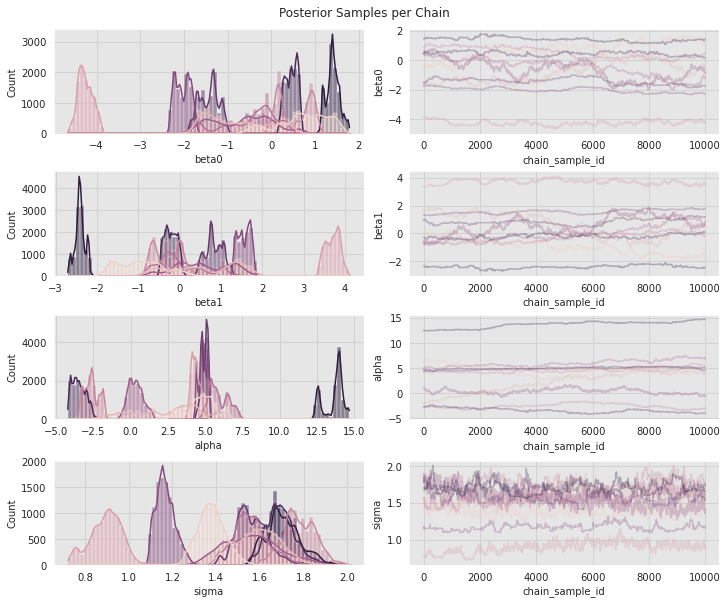

In [11]:
chains_df = chains_to_df(chain, num_chains, vars)
# chains_df
plot_chain_traces(params, num_chains, chains_df)
#

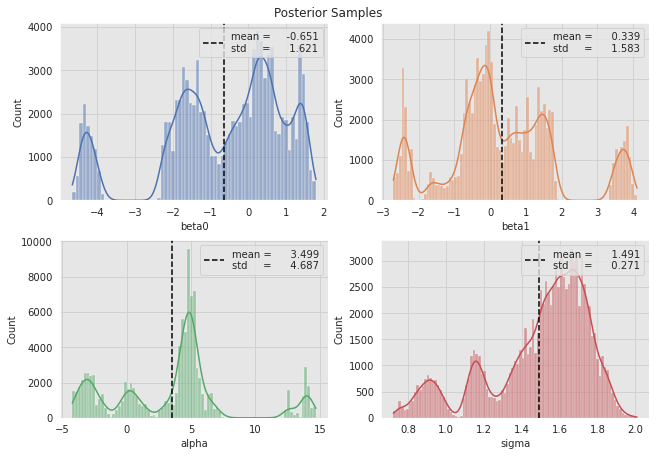

In [12]:
plot_chain_sum(params, chains_df )
#


 Test data

mu_posterior_std  chi-sq and rms: 308.19 14.173
   posterior_std  chi-sq and rms:  95.73 14.172


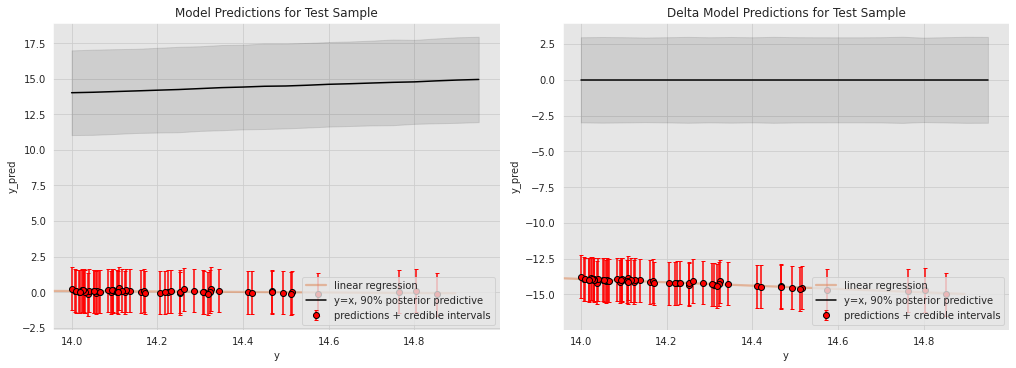

In [13]:
answers = make_posterior_means_from_chains(chain, X_test, y_test, params, verbose=False)    
yp_on_yt_plot (answers["posterior_mean"], answers["posterior_std"], y_test, answers["ppd_df"])
#